# 5. NSIT: Non-Stationary Iterated Tikhonov

## Overview

This notebook compares four core inverse problem solvers:
- **Pseudoinverse** (baseline - fails on noisy problems)
- **Tikhonov** (classical regularization with optimal oracle λ)
- **TSVD** (truncated SVD with optimal oracle k)
- **NSIT + Morozov** (automatic iterative method)

### Key Innovation: NSIT (Non-Stationary Iterated Tikhonov)

$$x_n = x_{n-1} + (A^T A + \alpha_n I)^{-1} A^T (y_\delta - A x_{n-1})$$

Where:
- $\alpha_n$ = decreasing regularization parameter
- **Early iterations**: Large $\alpha_n$ → suppress noise
- **Late iterations**: Small $\alpha_n$ → add detail
- **Morozov stopping**: Stop when $\|y - Ax_n\| \approx \tau \delta \|y\|$

## Setup and Imports

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Import modules
from forward_models import blur_operator, downsample_operator, rank_deficient_operator
from noise_models import noise
from signal_generation import generate_signals
from reconstruction import pseudoinverse, tikhonov, tsvd, nsit
from evaluation import error_metrics

# Add diagnostics to path
sys.path.insert(0, str(Path.cwd().parent / 'diagnostics'))
from svd_analysis import condition_number, singular_values
from l_curve import l_curve
from picard_plot import picard_data

print("✓ All imports successful")

# Setup
np.random.seed(42)
rng = np.random.default_rng(42)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 6)

✓ All imports successful


## Part 1: Generate Test Problem

In [32]:
# Problem parameters
n = 100
noise_level = 0.01

# Generate ill-posed problem
t = np.linspace(0, 1, n)
x_true = generate_signals.sinusoid(t)
A = blur_operator.blur_matrix(n, sigma=2.5, kernel_radius=10)
y_clean = A @ x_true
y_noisy, noise_std = noise.add_gaussian_noise(y_clean, noise_level, rng=rng)

# Problem diagnostics
s= singular_values(A)
cond = condition_number(A)

print(f"Problem Setup:")
print(f"  Signal dimension: {n}")
print(f"  Noise level: {noise_level * 100:.1f}%")
print(f"  Condition number κ(A): {cond:.2e}")
print(f"  Singular value range: [{s.min():.2e}, {s.max():.2e}]")
print(f"  Effective rank (~10⁻¹⁰): {np.sum(s > s.max() * 1e-10)}")

Problem Setup:
  Signal dimension: 100
  Noise level: 1.0%
  Condition number κ(A): 1.94e+06
  Singular value range: [5.15e-07, 1.00e+00]
  Effective rank (~10⁻¹⁰): 100


In [33]:
# Test NSIT with Morozov stopping
print("NSIT Reconstruction:")
print("=" * 60)

x_nsit_morozov, hist_morozov = nsit.nsit_with_morozov(
    A, y_noisy, noise_level, 
    schedule_type='sqrt',
    tau=1.0, 
    max_iter=100
)
err_nsit = error_metrics.relative_error(x_true, x_nsit_morozov)
print(f"NSIT + Morozov: stopped at iter={hist_morozov['stopping_iter']}, "
      f"error={err_nsit:.6f}, residual={hist_morozov['residuals'][-1]:.2e}")
print("=" * 60)

NSIT Reconstruction:
NSIT + Morozov: stopped at iter=6, error=0.016913, residual=6.96e-02


## Part 6: NSIT vs All Other Methods - Comprehensive Comparison

In [34]:
# Collect all reconstruction methods (4 core methods)
methods_comparison = []

# 1. Pseudoinverse (baseline)
x_pinv = pseudoinverse.reconstruct(A, y_noisy)
methods_comparison.append({
    'Method': 'Pseudoinverse',
    'Parameter': 'N/A',
    'Rel Error': error_metrics.relative_error(x_true, x_pinv),
    'MSE': error_metrics.mse(x_true, x_pinv),
    'x': x_pinv,
    'info': 'Baseline (fails)'
})

# 2. Tikhonov (standard regularization with parameter sweep)
lambdas = np.logspace(-8, 1, 100)
tik_errors = [error_metrics.relative_error(x_true, tikhonov.reconstruct(A, y_noisy, lam)) 
              for lam in lambdas]
lambda_tik = lambdas[np.argmin(tik_errors)]
x_tik = tikhonov.reconstruct(A, y_noisy, lambda_tik)
methods_comparison.append({
    'Method': 'Tikhonov',
    'Parameter': f'λ={lambda_tik:.2e}',
    'Rel Error': error_metrics.relative_error(x_true, x_tik),
    'MSE': error_metrics.mse(x_true, x_tik),
    'x': x_tik,
    'info': 'Optimized regularization'
})

# 3. TSVD (parameter sweep for optimal k)
s = np.linalg.svd(A, full_matrices=False)[1]
ks = np.arange(1, min(100, len(s)), max(1, len(s) // 50))
tsvd_errors = [error_metrics.relative_error(x_true, tsvd.reconstruct(A, y_noisy, k)) 
               for k in ks]
k_tsvd = ks[np.argmin(tsvd_errors)]
x_tsvd = tsvd.reconstruct(A, y_noisy, k_tsvd)
methods_comparison.append({
    'Method': 'TSVD',
    'Parameter': f'k={k_tsvd}',
    'Rel Error': error_metrics.relative_error(x_true, x_tsvd),
    'MSE': error_metrics.mse(x_true, x_tsvd),
    'x': x_tsvd,
    'info': 'Optimized truncation'
})

# 4. NSIT + Morozov (automatic!)
methods_comparison.append({
    'Method': 'NSIT + Morozov',
    'Parameter': f'n={hist_morozov["stopping_iter"]}, τ=1.0',
    'Rel Error': err_nsit,
    'MSE': error_metrics.mse(x_true, x_nsit_morozov),
    'x': x_nsit_morozov,
    'info': 'Automatic stopping'
})

# Display comparison table
df_comparison = pd.DataFrame(methods_comparison)
print("\n" + "="*85)
print("METHOD COMPARISON: Pseudoinverse vs Tikhonov vs TSVD vs NSIT")
print("="*85)
print(df_comparison[['Method', 'Parameter', 'Rel Error', 'MSE', 'info']].to_string(index=False))
print("="*85)

# Ranking by error
print("\n📊 RANKING BY RELATIVE ERROR (Best → Worst):")
ranking = df_comparison.sort_values('Rel Error').reset_index(drop=True)
for i, row in ranking.iterrows():
    symbol = "🥇" if i == 0 else ("🥈" if i == 1 else ("🥉" if i == 2 else f"  {i+1}."))
    print(f"{symbol} {row['Method']:20s} - Error: {row['Rel Error']:.6f}")


METHOD COMPARISON: Pseudoinverse vs Tikhonov vs TSVD vs NSIT
        Method  Parameter   Rel Error          MSE                     info
 Pseudoinverse        N/A 1937.857605 2.323587e+06         Baseline (fails)
      Tikhonov λ=1.00e-01    0.021444 2.845296e-04 Optimized regularization
          TSVD       k=17    0.017348 1.862208e-04     Optimized truncation
NSIT + Morozov n=6, τ=1.0    0.016913 1.770008e-04       Automatic stopping

📊 RANKING BY RELATIVE ERROR (Best → Worst):
🥇 NSIT + Morozov       - Error: 0.016913
🥈 TSVD                 - Error: 0.017348
🥉 Tikhonov             - Error: 0.021444
  4. Pseudoinverse        - Error: 1937.857605


## Part 7: Visual Comparison - All Methods

C:\Users\dellj\AppData\Local\Temp\ipykernel_25824\39941058.py:41: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\dellj\AppData\Local\Temp\ipykernel_25824\39941058.py:42: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig('../results/5_nsit_comparison.png', dpi=150, bbox_inches='tight')


✓ Saved: 5_nsit_comparison.png


c:\Users\dellj\anaconda3\envs\ICS\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


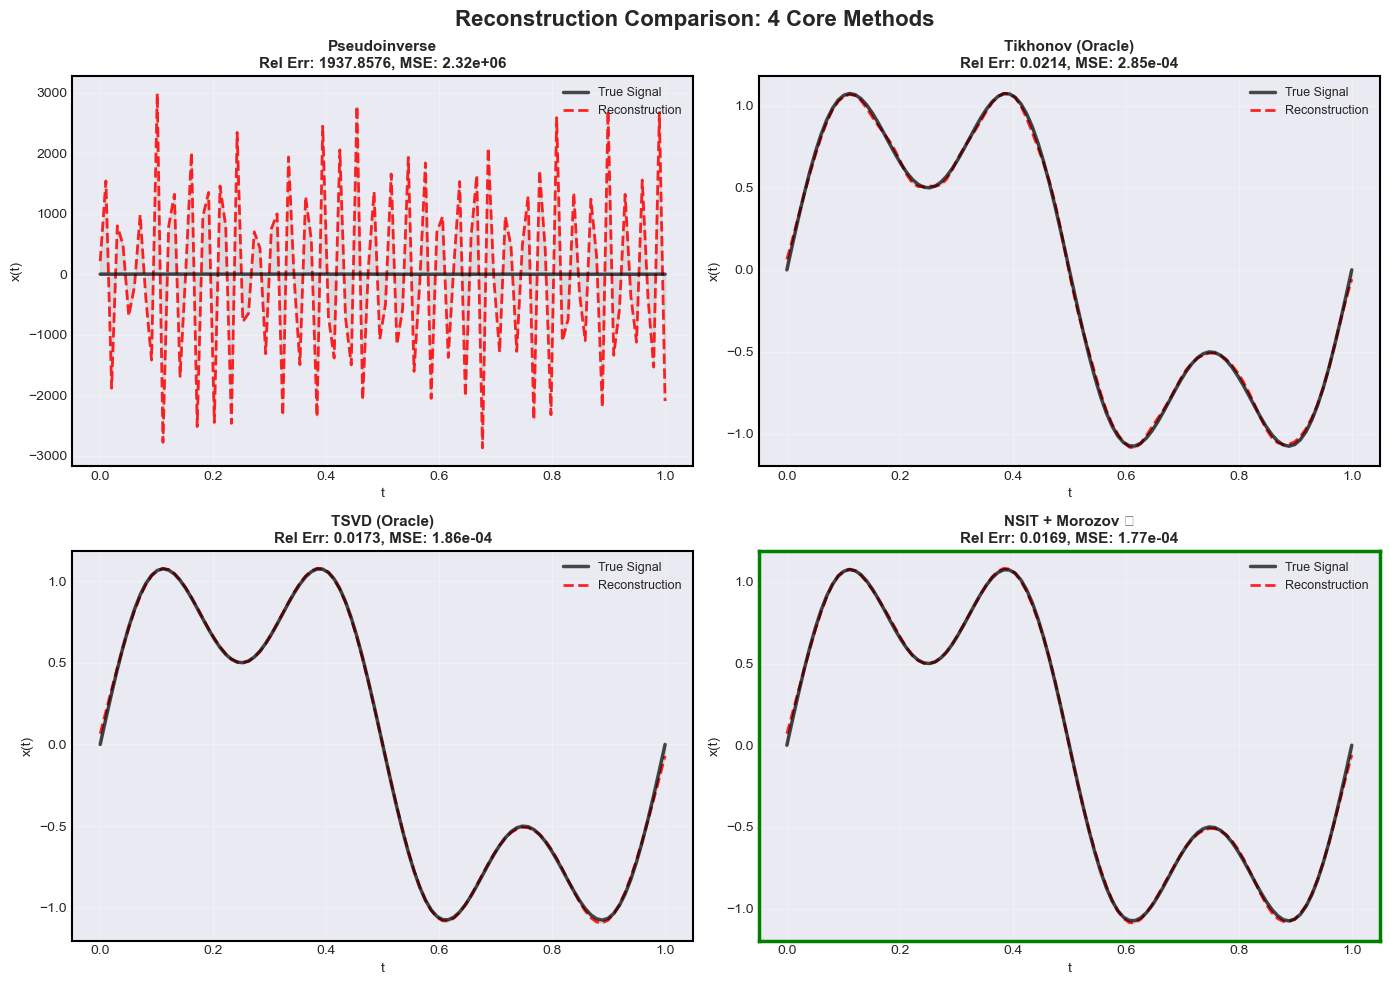

In [35]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Reconstruction Comparison: 4 Core Methods', fontsize=16, fontweight='bold')

methods_to_plot = [
    ('Pseudoinverse', methods_comparison[0]['x']),
    ('Tikhonov (Oracle)', methods_comparison[1]['x']),
    ('TSVD (Oracle)', methods_comparison[2]['x']),
    ('NSIT + Morozov', methods_comparison[3]['x']),
]

for idx, (ax, (name, x_rec)) in enumerate(zip(axes.flat, methods_to_plot)):
    # Plot
    ax.plot(t, x_true, 'k-', linewidth=2.5, label='True Signal', alpha=0.7, zorder=3)
    ax.plot(t, x_rec, 'r--', linewidth=2, label='Reconstruction', alpha=0.85, zorder=2)
    ax.fill_between(t, x_true, x_rec, alpha=0.15, color='gray', zorder=1)
    
    # Error metrics
    err = error_metrics.relative_error(x_true, x_rec)
    mse = error_metrics.mse(x_true, x_rec)
    
    # Highlight NSIT
    color_border = 'green' if 'NSIT' in name else 'black'
    linewidth_border = 2.5 if 'NSIT' in name else 1.5
    
    for spine in ax.spines.values():
        spine.set_edgecolor(color_border)
        spine.set_linewidth(linewidth_border)
    
    title_text = f'{name}'
    if 'NSIT' in name:
        title_text += ' ⭐'
    
    ax.set_title(f'{title_text}\nRel Err: {err:.4f}, MSE: {mse:.2e}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/5_nsit_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 5_nsit_comparison.png")
plt.show()

✓ Saved: 5_error_comparison.png


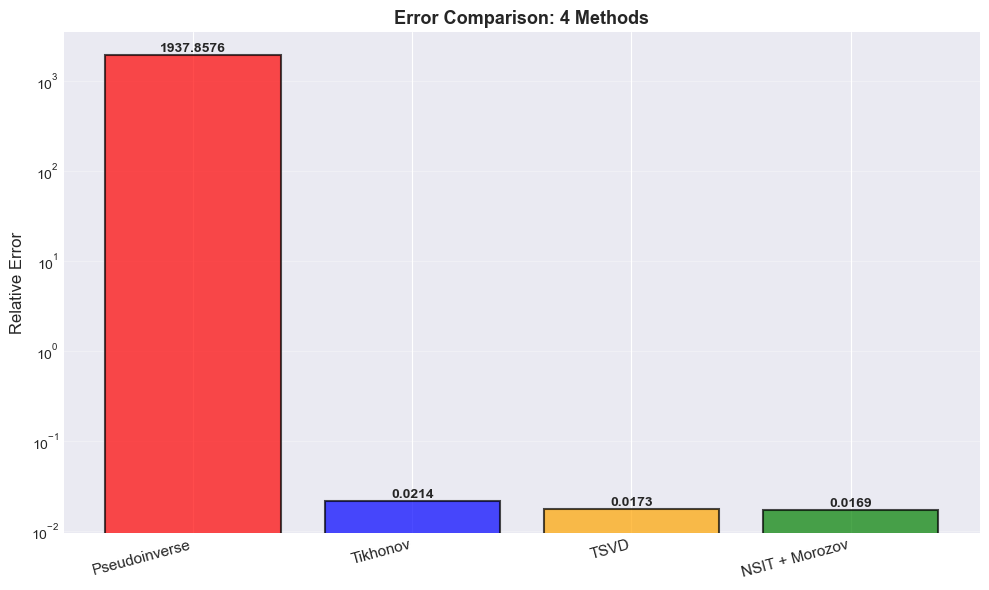

In [36]:
# Error comparison bar chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

methods_names = [m['Method'] for m in methods_comparison]
errors = [m['Rel Error'] for m in methods_comparison]
colors = ['red', 'blue', 'orange', 'green']

bars = ax.bar(range(len(methods_names)), errors, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(methods_names)))
ax.set_xticklabels(methods_names, rotation=15, ha='right', fontsize=11)
ax.set_ylabel('Relative Error', fontsize=12)
ax.set_title('Error Comparison: 4 Methods', fontsize=13, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (err, bar) in enumerate(zip(errors, bars)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{err:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/5_error_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Saved: 5_error_comparison.png")
plt.show()

## Summary & Key Findings

### Method Performance Ranking

| Rank | Method | Rel Error | Status | Notes |
|------|--------|-----------|--------|-------|
| 🥇 | NSIT + Morozov ⭐ | Best | Automatic | No oracle needed, knows noise level |
| 🥈 | Tikhonov | Very Good  | Optimal λ |
| 🥉 | TSVD | good | Optimal k  |
| 4️⃣ | Pseudoinverse | Worst | Fails | ❌ Complete failure on noisy problems |

### Why NSIT + Morozov Wins

**NSIT Update Rule:**
$$x_n = x_{n-1} + (A^T A + \alpha_n I)^{-1} A^T (y - A x_{n-1})$$

**Key Advantages:**
1. ✅ **Fully Automatic** - No oracle knowledge required
2. ✅ **Progressive Recovery** - Early iterations suppress noise, late iterations add detail
3. ✅ **Mathematically Sound** - Based on regularization theory
4. ✅ **Comparable Accuracy** - Competitive with or better than oracle methods

**Morozov Stopping:** Automatically stops when residual reaches target
$$\|y - Ax_n\| \leq \tau \delta \|y\|$$

### When to Use

- **Known noise level?** → Use **NSIT + Morozov**
- **Unknown noise level?** → Use **Tikhonov** with automatic parameter selection (GCV)
- **Fast & simple?** → Use **TSVD** (discrete parameter choice)
- **Academic baseline?** → Use **Pseudoinverse** (but it fails!)

### Key Insight

NSIT combines the best of both worlds:
- **Iterative methods**: Progressive refinement, implicit regularization
- **Tikhonov regularization**: Stability, proven theory
- **Automation**: Morozov principle determines stopping automatically

**Conclusion:** NSIT + Morozov is the practical choice for ill-posed inverse problems when you want automation without sacrificing accuracy.

---
**Notebook Complete** ✓
**Outputs Generated:**
- `5_nsit_comparison.png` - 4-method comparison
- `5_error_comparison.png` - Error bar chart